In [1]:
# Dictate the environment's loctaion of REFPROP
import os
os.environ['RPPREFIX'] = r'C:/Program Files (x86)/REFPROP'

In [2]:
# Import the main class from the Python library
from ctREFPROP.ctREFPROP import REFPROPFunctionLibrary

# Imports from conda-installable packages
import pandas as pd

# Import numpy
import numpy as np

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Import Math for common values such as PI
import math


In [3]:
# Instantiate the library, and use the environment variable to explicitly state which path we want to use.
# As mentioned above, this will be changed to call the correct REFPROP functions to be used
# with MINI-REFPROP and 32-bit python.
# If using MINI-REFPROP and 32-bit python please make the following changes
# RP = REFPROPFunctionLibrary('C:/Program FIles (x86)/MINI-REFPROP\\REFPROP.DLL')
RP = REFPROPFunctionLibrary(os.environ['RPPREFIX'])

In [4]:
# This will call which root directory that will be used for the program. 
RP.SETPATHdll(os.environ['RPPREFIX'])

In [5]:
# Get the unit system we want to use (Mass base SI gives units in
# K, Pa, kg, m, N, J, W, and s)
MASS_BASE_SI = RP.GETENUMdll(0, "MASS BASE SI").iEnum

### Basic sCO2 States Derived

In [6]:
m_dot = .2 # kg/s of mass flow rate of sCO2

#### Outlet of Heat Source, Inlet of Engine

In [7]:
T2 = 88 # [C]
P2 = 2500 # [psia]

T2 = T2 + 273.15 # Convert C to Kelvin
P2 = P2 * 6894.8 # convert psia to Pa

print("Pressure at Outlet of Heat Source =", P2/6894.8, "psia")
print("Temperature at Outlet of Heat Source =" , (T2 - 273.15) * (9/5) + 32, "F")

Pressure at Outlet of Heat Source = 2500.0 psia
Temperature at Outlet of Heat Source = 190.4 F


In [8]:
# Obtain fluid properties from the pressure and enthalpy outlined above
State_2 = RP.REFPROPdll("CO2","PT","H;D;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P2,T2,[1.0])

# Outputs will be placed into data frame for organization
State_2 = pd.DataFrame(State_2.Output[0:9],
            index = ['Enthalpy [J/kg]','Density [kg/m^3]', 'Volume [m^3/kg]', 'Entropy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 2'])

# Display the data frame
State_2

,State 2
Enthalpy [J/kg],414772.202437
Density [kg/m^3],462.360653
Volume [m^3/kg],0.002163
Entropy [J/kg],1619.615557
CP/CV,2.880774
Speed of Sound,291.838963
Thermal Cond. [W/(mK)],0.053589
Viscosity [Pa-s],0.000035
Prandtl,1.714147


#### Outlet of Engine, Inlet of Heat Exchanger

In [9]:
# Engine Parameters
mass_cylinder = State_2.loc['Density [kg/m^3]', 'State 2'] * .000308276
State_3_den = mass_cylinder / .000454574

# With Isentropic expansion
State_3_entr = State_2.loc['Entropy [J/kg]', 'State 2']

State_3_isen = RP.REFPROPdll("CO2","DS","P;T;V;H;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,State_3_den,State_3_entr,[1.0])

# Outputs will be placed into data frame for organization
State_3_isen = pd.DataFrame(State_3_isen.Output[0:9],
            index = ['Pressure [Pa]', 'Temperature [K]', 'Volume [m^3/kg]', 'Enthalpy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 3 Isentropic'])


In [10]:
# Account for Issentropic Efficiency
Isen_eff = .7
State_3_enth_new = State_2.loc['Enthalpy [J/kg]','State 2'] - (Isen_eff * (State_2.loc['Enthalpy [J/kg]','State 2'] - State_3_isen.loc['Enthalpy [J/kg]', 'State 3 Isentropic']))

# Using Pressure and enthalpy find the states of the fluid at the Outlet of Engine

State_3 = RP.REFPROPdll("CO2","PH","D;T;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,State_3_isen.loc['Pressure [Pa]', 'State 3 Isentropic'],State_3_enth_new,[1.0])

# Outputs will be placed into data frame for organization
State_3 = pd.DataFrame(State_3.Output[0:9],
            index = ['Density [kg/m^3]','Temperature [K]', 'Volume [m^3/kg]', 'Entropy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 3'])


#### Outlet of Heat Exchanger, Inlet to Compressor

In [11]:
P4 = State_3_isen.loc['Pressure [Pa]', 'State 3 Isentropic']

Q_out = -8.2 # kW heat removed by Heat Exchanger

h4 = Q_out * 1000 / (m_dot) + State_3_enth_new

In [12]:
# Obtain fluid properties from the pressure and enthalpy outlined above
State_4 = RP.REFPROPdll("CO2","PH","T;D;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P4,h4,[1.0])

# Outputs will be placed into data frame for organization
State_4 = pd.DataFrame(State_4.Output[0:9],
            index = ['Temperature [K]','Density [kg/m^3]', 'Volume [m^3/kg]', 'Entropy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 4'])

#### Outlet of Compressor, Inlet to Heat Source Isentropic

In [13]:
# Find the Isentropic Outlet of the Compressor
State_1_isen = RP.REFPROPdll("CO2","PS","T;D;V;H;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P2,State_4.loc['Entropy [J/kg]', 'State 4'],[1.0])
State_1_isen = pd.DataFrame(State_1_isen.Output[0:9],
            index = ['Temperature [K]','Density [kg/m^3]', 'Volume [m^3/kg]', 'Enthalpy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 1 Isentropic'])

In [14]:
# Account for Issentropic Efficiency
Isen_eff = .85
State_1_enth_new = h4 + ((State_1_isen.loc['Enthalpy [J/kg]', 'State 1 Isentropic'] - h4)/Isen_eff)

In [15]:
State_1 = RP.REFPROPdll("CO2","PH","T;D;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P2,State_1_enth_new,[1.0])

# Outputs will be placed into data frame for organization
State_1 = pd.DataFrame(State_1.Output[0:9],
            index = ['Temperature [K]', 'Density [kg/m^3]', 'Volume [m^3/kg]', 'Entropy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 1'])

In [16]:
State_2.loc['Pressure [Pa]', 'State 2'] = P2
State_2.loc['Temperature [K]', 'State 2'] = T2
State_3_isen.loc['Density [kg/m^3]', 'State 3 Isentropic'] = State_3_den
State_3_isen.loc['Entropy [J/kg]', 'State 3 Isentropic'] = State_3_entr
State_3.loc['Enthalpy [J/kg]', 'State 3'] = State_3_enth_new
State_3.loc['Pressure [Pa]', 'State 3'] = State_3_isen.loc['Pressure [Pa]', 'State 3 Isentropic']
State_4.loc['Pressure [Pa]', 'State 4'] = P4
State_4.loc['Enthalpy [J/kg]', 'State 4'] = h4
State_1_isen.loc['Entropy [J/kg]', 'State 1 Isentropic'] = State_4.loc['Entropy [J/kg]', 'State 4']
State_1_isen.loc['Pressure [Pa]', 'State 1 Isentropic'] = P2
State_1.loc['Enthalpy [J/kg]', 'State 1'] = State_1_enth_new
State_1.loc['Pressure [Pa]', 'State 1'] = State_1_isen.loc['Pressure [Pa]', 'State 1 Isentropic']

In [17]:
# Combine the data frames into one data frame for ease of use
sCO2_States = pd.concat([State_1_isen, State_1, State_2, State_3_isen, State_3, State_4], axis =1)

# Reorder the Data Frame
sCO2_States = sCO2_States.reindex(["Pressure [Pa]", "Temperature [K]", 'Density [kg/m^3]', 'Volume [m^3/kg]', 'Enthalpy [J/kg]',
                     'Entropy [J/kg]', 'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 
                     'Prandtl' ])

# Display the data frame
sCO2_States

,State 1 Isentropic,State 1,State 2,State 3 Isentropic,State 3,State 4
Pressure [Pa],1.723700e+07,1.723700e+07,1.723700e+07,8.351911e+06,8.351911e+06,8.351911e+06
Temperature [K],3.474071e+02,3.484821e+02,3.611500e+02,3.138944e+02,3.150604e+02,3.105478e+02
Density [kg/m^3],5.566761e+02,5.484311e+02,4.623607e+02,3.135566e+02,2.976036e+02,4.127311e+02
Volume [m^3/kg],1.796377e-03,1.823383e-03,2.162814e-03,3.189217e-03,3.360175e-03,2.422885e-03
Enthalpy [J/kg],3.759455e+05,3.791278e+05,4.147722e+05,3.921162e+05,3.989130e+05,3.579130e+05
Entropy [J/kg],1.509966e+03,1.519112e+03,1.619616e+03,1.619616e+03,1.641230e+03,1.509966e+03
CP/CV,3.177562e+00,3.167072e+00,2.880774e+00,5.988800e+00,5.135798e+00,1.445877e+01
Speed of Sound,3.109282e+02,3.085568e+02,2.918390e+02,2.030412e+02,2.063522e+02,1.896631e+02
Thermal Cond. [W/(mK)],6.172936e-02,6.100759e-02,5.358901e-02,4.986973e-02,4.634190e-02,7.356931e-02
Viscosity [Pa-s],4.187644e-05,4.117298e-05,3.479425e-05,2.355055e-05,2.288181e-05,2.887508e-05


In [18]:
# Plot States on T-S Diagram
S_CO2_1 = []
S_CO2_2 = []
T_CO2 = []
T = 273.125 # K

for x in range(0,20000):
    CO2_S = RP.REFPROPdll("CO2","TQMASS","S", MASS_BASE_SI,0,0, T + 31*(x/20000), 0,[1.0]).Output[0]
    S_CO2_1.append(CO2_S/1000)
    CO2_S = RP.REFPROPdll("CO2","TQMASS","S", MASS_BASE_SI,0,0, T + 31*(x/20000), 1,[1.0]).Output[0]
    S_CO2_2.append(CO2_S/1000)
    T_CO2.append(T + 31*(x/20000))

In [19]:
T_CO2_P1 = []
T_CO2_P2 = []
S_P1 = []
T_CO2_P3 = []

for x in range(0,1000):
    CO2_T = RP.REFPROPdll("CO2","PS","T", MASS_BASE_SI,0,0, 1.723700e+07, (1 + .8 * (x/1000))*1000 ,[1.0]).Output[0]
    T_CO2_P1.append(CO2_T-273.125)
    S_P1.append(1 + .8 * (x/1000))
    CO2_T = RP.REFPROPdll("CO2","PS","T", MASS_BASE_SI,0,0, 8.351911e+06, (1 + .8 * (x/1000))*1000 ,[1.0]).Output[0]
    T_CO2_P2.append(CO2_T-273.125)

In [20]:
Isentropic_T = [sCO2_States.loc['Temperature [K]', 'State 1 Isentropic'],sCO2_States.loc['Temperature [K]', 'State 2'],sCO2_States.loc['Temperature [K]', 'State 3 Isentropic'],\
                sCO2_States.loc['Temperature [K]', 'State 4'],sCO2_States.loc['Temperature [K]', 'State 1 Isentropic'] ]
Actual_T = [sCO2_States.loc['Temperature [K]', 'State 1'],sCO2_States.loc['Temperature [K]', 'State 2'],sCO2_States.loc['Temperature [K]', 'State 3'],\
                sCO2_States.loc['Temperature [K]', 'State 4'],sCO2_States.loc['Temperature [K]', 'State 1'] ]
S_Isentropic = [sCO2_States.loc['Entropy [J/kg]', 'State 1 Isentropic'],sCO2_States.loc['Entropy [J/kg]', 'State 2'],sCO2_States.loc['Entropy [J/kg]', 'State 3 Isentropic'],\
                sCO2_States.loc['Entropy [J/kg]', 'State 4'],sCO2_States.loc['Entropy [J/kg]', 'State 1 Isentropic'] ]
S_Actual = [sCO2_States.loc['Entropy [J/kg]', 'State 1'],sCO2_States.loc['Entropy [J/kg]', 'State 2'],sCO2_States.loc['Entropy [J/kg]', 'State 3'],\
                sCO2_States.loc['Entropy [J/kg]', 'State 4'],sCO2_States.loc['Entropy [J/kg]', 'State 1'] ]


In [21]:
T_merge = [31,31]
S_merge = [1.415, 1.45]
Isentropic_T = np.array(Isentropic_T) - 273.125
Actual_T = np.array(Actual_T) - 273.125
S_Isentropic = np.array(S_Isentropic)/1000
S_Actual = np.array(S_Actual)/1000
T_CO2 = np.array(T_CO2) - 273.125

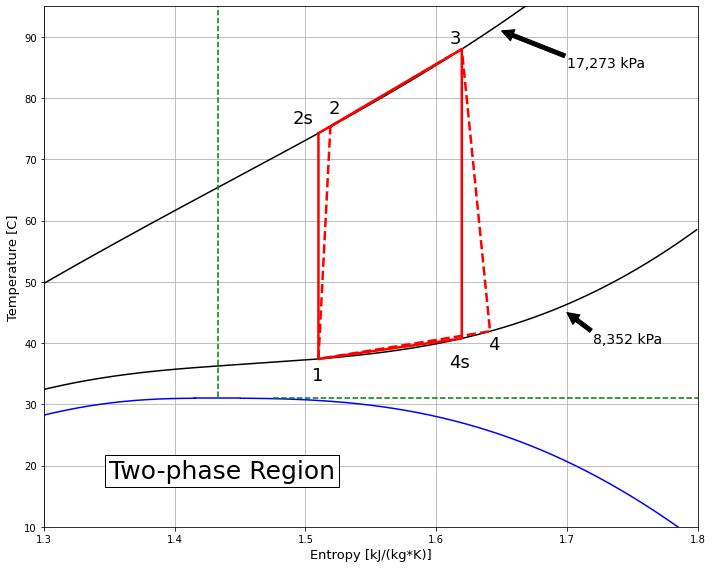

In [24]:
plt.figure(figsize=(10,8), tight_layout=True)

plt.plot(S_CO2_1, T_CO2, 'b', linewidth = 1.5 )
plt.plot(S_CO2_2, T_CO2, 'b', linewidth = 1.5 )
plt.plot(S_merge, T_merge,'b', linewidth = 1.5)
plt.plot(S_P1, T_CO2_P1,'k',linewidth=1.5)
plt.plot(S_P1, T_CO2_P2,'k',linewidth=1.5)
plt.axvline(x = 1.4331, ymin= .25,  color = 'g', linestyle = '--')
plt.axhline(y=31, xmin = .35, color = 'g', linestyle = '--')
plt.plot(S_Isentropic, Isentropic_T, '-r', linewidth = 2.5)
plt.plot(S_Actual, Actual_T, '--r', linewidth = 2.5)

plt.grid(True)
plt.xlabel('Entropy [kJ/(kg*K)]', fontsize = 13)
plt.ylabel('Temperature [C]', fontsize = 13)
plt.axis([1.3,1.8,10,95])
plt.annotate('8,352 kPa', xy = (1.7, 45), fontsize = 14, xytext = (1.72, 40),arrowprops = dict(facecolor = 'black'),
             color = 'k')
plt.annotate('17,273 kPa', xy = (1.65, 91), fontsize = 14, xytext = (1.7, 85),arrowprops = dict(facecolor = 'black'),
             color = 'k')
plt.text(1.505, 34, '1', fontsize = 18)
plt.text(1.518, 77.5, '2', fontsize = 18)
plt.text(1.49, 76, '2s', fontsize = 18)
plt.text(1.61, 89, '3', fontsize = 18)
plt.text(1.61, 36, '4s', fontsize = 18)
plt.text(1.64, 39, '4', fontsize = 18)
plt.text(1.35, 18, 'Two-phase Region', fontsize = 25,
        bbox = dict(facecolor = 'white'))

plt.savefig('T-S_Diagram.png',bbox_inches='tight')

plt.show()